In [3]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd
import librosa
import librosa.display
import os
from os import path
import io
!pip3 install soundfile
!pip3 install librosa
import soundfile as sf
import librosa.feature

In [4]:
!pip install ipython-autotime

%load_ext autotime

# Opening datasets

In [5]:
DIR = '/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class' 
DIR_AUDIO = DIR + '/soundfiles/TAU-urban-acoustic-scenes-2020-3class-development/'
df_meta = pd.read_csv(f'{DIR}/meta.csv')
df_meta = pd.read_csv(io.StringIO(df_meta.to_csv(index=False)))
df_meta.head()

,filename,scene_label,identifier
0,audio/airport-barcelona-0-0-a.wav,indoor,barcelona-0
1,audio/airport-barcelona-0-10-a.wav,indoor,barcelona-0
2,audio/airport-barcelona-0-11-a.wav,indoor,barcelona-0
3,audio/airport-barcelona-0-12-a.wav,indoor,barcelona-0
4,audio/airport-barcelona-0-13-a.wav,indoor,barcelona-0


time: 101 ms


# Getting part of the dataset
Não coloquei 10% dele, pois poderiam vir mais datasets de um label específico. E nem coloquei 10% de cada label, pois a quantidades de datasets dentro de cada label é diferente. Então defini n datasets de cada label.

In [357]:
df = df_meta.groupby('scene_label', as_index=False).apply(lambda x: x.sample(n=100, random_state=15))
df.index = [i[1] for i in df.index]
df.head()

,filename,scene_label,identifier
3028,audio/metro_station-helsinki-231-6952-a.wav,indoor,helsinki-231
9493,audio/shopping_mall-milan-1183-45376-a.wav,indoor,milan-1183
4163,audio/metro_station-stockholm-85-2308-a.wav,indoor,stockholm-85
3224,audio/metro_station-lisbon-1020-42471-a.wav,indoor,lisbon-1020
9294,audio/shopping_mall-lyon-1066-42583-a.wav,indoor,lyon-1066


time: 30.6 ms


In [358]:
# so neste caso q n vamos usar transportation
df = df.loc[df['scene_label'] != 'transportation']

time: 2.91 ms


In [359]:
print(df.loc[df['scene_label'] == 'outdoor'].shape)
print(df.loc[df['scene_label'] == 'indoor'].shape)
print(df.loc[df['scene_label'] == 'transportation'].shape)

(100, 3)
(100, 3)
(0, 3)
time: 7.21 ms


Reading the datasets and storing it to 'signals'

In [360]:
info_sound = df[['filename','scene_label']].to_numpy()
LABELS = ['indoor', 'outdoor']

time: 9.12 ms


In [361]:
dic_signals = {x:[] for i, x in enumerate(LABELS)}

for filename, label in info_sound:
    if(path.isfile(os.path.join(DIR_AUDIO, filename))):
        dic_signals[label].append(sf.read(os.path.join(DIR_AUDIO, filename)))

time: 49.2 s


Labels:


0.   Indoor
1.   Outdoor
2.   Transportation



# Getting Features

1.   Centroid Mean
2.   Centroid STD
3.   Flatness Mean
4.   Flatness STD
5.   RMS



In [362]:
PARTS = 10
def get_features(dic_signals)->pd.DataFrame:
    # LUANA - FEATURES
    def get_centroid(S):
        return librosa.feature.spectral_centroid(S=S)
    def get_flatness(S):
        return librosa.feature.spectral_flatness(S=S)
    def get_rms(S):
        return librosa.feature.rms(S=S)
    def get_mfccs(S):
        return librosa.feature.mfcc(S=S)

    feats = (np.zeros((1,47))[0])
    
    j = 1
    k = 0 #label
    for label, signals in dic_signals.items():
        for signal, samplerate in signals:
            music_features = []
            #print(np.array(signal).shape)
            mel = librosa.feature.melspectrogram(y=signal[:,0],sr=samplerate, hop_length=512)
            mel = np.asarray(mel)
            #print(mel.shape)
            
            for second in np.array_split(mel,10, axis=1):
                arr_mfcc = []
                #print(second.shape)
                c = get_centroid(second)
                f = get_flatness(second)
                r = get_rms(second)
                mfccs = get_mfccs(second)
                mfccs = [[np.mean(x), np.std(x)] for x in mfccs]
                mfccs = np.array(mfccs).reshape(1,-1)[0]
                #print(mfccs)
                mfccs = np.array_split(mfccs, mfccs.shape[0])
                #print(np.array(mfccs).shape)
                [arr_mfcc.append(x[0]) for x in mfccs]
                music_features = np.hstack([arr_mfcc, np.array([np.mean(c),np.std(c),np.mean(f), np.std(f),r[0][0], k, j])]) 
                #print(np.array(music_features).shape)
                
                feats = np.vstack([feats, music_features])  
            j += 1
        k += 1
    return pd.DataFrame(data=feats).drop(0).reset_index(drop=True)
        


time: 30.8 ms


In [363]:
df = get_features(dic_signals)

time: 20.1 s


In [364]:
df.to_csv("/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/features.csv")

time: 207 ms


In [365]:
df = pd.read_csv("/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/features.csv").drop("Unnamed: 0",axis=1) 
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
0,0.019938,0.009934,0.027834,0.013968,0.027035,0.013797,0.026155,0.013626,0.025392,0.013511,0.024744,0.013460,0.024217,0.013460,0.023745,0.013492,0.023244,0.013501,0.022672,0.013448,0.022076,0.013330,0.021470,0.013166,0.020903,0.012989,0.020412,0.012812,0.020006,0.012644,0.019657,0.012481,0.019292,0.012311,0.018846,0.012127,0.018277,0.011939,0.017648,0.011770,241.434983,124.399592,0.000038,0.000100,0.003650,0.0,1.0
1,0.016892,0.009902,0.023406,0.013988,0.022291,0.013955,0.021040,0.013915,0.019878,0.013876,0.018829,0.013853,0.017930,0.013853,0.017221,0.013870,0.016657,0.013883,0.016204,0.013863,0.015846,0.013799,0.015544,0.013685,0.015286,0.013524,0.015084,0.013304,0.014931,0.013016,0.014785,0.012676,0.014584,0.012314,0.014274,0.011970,0.013857,0.011674,0.013386,0.011444,379.258576,190.165408,0.000091,0.000131,0.008548,0.0,1.0
2,0.018766,0.010781,0.026073,0.015206,0.025001,0.015157,0.023788,0.015178,0.022626,0.015245,0.021556,0.015303,0.020666,0.015364,0.019976,0.015439,0.019405,0.015489,0.018929,0.015474,0.018573,0.015381,0.018303,0.015205,0.018066,0.014949,0.017827,0.014631,0.017572,0.014295,0.017300,0.014002,0.016992,0.013782,0.016610,0.013616,0.016155,0.013475,0.015697,0.013348,336.841997,209.414420,0.000069,0.000139,0.001686,0.0,1.0
3,0.014968,0.007712,0.020849,0.010832,0.020133,0.010615,0.019290,0.010315,0.018386,0.010020,0.017407,0.009785,0.016447,0.009614,0.015573,0.009492,0.014774,0.009405,0.014047,0.009333,0.013453,0.009252,0.013006,0.009144,0.012693,0.009000,0.012493,0.008828,0.012383,0.008649,0.012333,0.008483,0.012294,0.008344,0.012218,0.008247,0.012064,0.008194,0.011834,0.008166,312.668493,119.726667,0.000057,0.000084,0.015298,0.0,1.0
4,0.012071,0.005576,0.016684,0.007842,0.015855,0.007705,0.014968,0.007490,0.014075,0.007252,0.013153,0.007024,0.012319,0.006813,0.011616,0.006623,0.010971,0.006470,0.010375,0.006362,0.009915,0.006291,0.009579,0.006254,0.009315,0.006250,0.009098,0.006267,0.008902,0.006289,0.008716,0.006293,0.008529,0.006265,0.008296,0.006202,0.007981,0.006109,0.007627,0.006007,394.402526,143.696832,0.000108,0.000123,0.002023,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1805,0.005549,0.003977,0.007735,0.005618,0.007500,0.005603,0.007312,0.005584,0.007213,0.005565,0.007151,0.005547,0.007092,0.005527,0.007032,0.005502,0.006963,0.005475,0.006885,0.005445,0.006809,0.005405,0.006739,0.005354,0.006672,0.005296,0.006605,0.005244,0.006536,0.005199,0.006455,0.005150,0.006364,0.005093,0.006269,0.005026,0.006178,0.004956,0.006086,0.004882,251.019948,130.671534,0.000234,0.000735,0.016265,1.0,181.0
1806,0.006777,0.005148,0.009463,0.007280,0.009212,0.007281,0.009002,0.007280,0.008886,0.007268,0.008839,0.007243,0.008822,0.007208,0.008786,0.007172,0.008706,0.007139,0.008599,0.007106,0.008493,0.007065,0.008410,0.007010,0.008358,0.006944,0.008320,0.006873,0.008270,0.006804,0.008180,0.006739,0.008045,0.006674,0.007897,0.006606,0.007767,0.006531,0.007664,0.006443,245.494152,160.557438,0.000208,0.000433,0.006400,1.0,181.0
1807,0.016557,0.021429,0.023230,0.030317,0.022849,0.030324,0.022552,0.030277,0.022407,0.030178,0.022314,0.030052,0.022218,0.029905,0.022128,0.029727,0.022036,0.029518,0.021910,0.029290,0.021722,0.029053,0.021466,0.028808,0.021182,0.028544,0.020935,0.028247,0.020737,0.027914,0.020536,0.027565,0.020288,0.027206,0.020015,0.026824,0.019738,0.026410,0.019433,0.025978,213.589903,190.892977,0.000144,0.000535,0.029016,1.0,181.0
1808,0.034513,0.039215,0.048670,0.055433,0.048356,0.055344,0.048033,0.055178,0.047758,0.054934,0.047494,0.054619,0.047202,0.054232,0.046856,0.053777,0.046436,0.053257,0.045947,0.052678,0.045410,0.052041,0.044832,0.051346,0.044212,0.050595,0.043568,0.049786,0.042913,0.048918,0.042228,0.048000,0.041485,0.04704

time: 116 ms


In [366]:
from sklearn.model_selection import GroupShuffleSplit

time: 951 µs


Split no dataframe baseado em grupos do número da música

In [367]:
train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 42).split(df, groups=df['46']))

time: 3.45 ms


In [368]:
import random

time: 590 µs


In [369]:
X_train = (df.iloc[train_inds, 0:-2]).sample(frac=1)
X_test = (df.iloc[test_inds,0:-2]).sample(frac=1)
y_train = (df.iloc[train_inds,[-2,-1]]).sample(frac=1).values
y_test = (df.iloc[test_inds,[-2,-1]]).sample(frac=1).values

time: 12.4 ms


In [370]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1440, 45), (370, 45), (1440, 2), (370, 2))

time: 3.3 ms


In [371]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

time: 1.2 ms


In [372]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

time: 8.03 ms


In [373]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

time: 1.22 ms


# Building a KNN Model

In [374]:
def knn_classifier(X_train, X_test, y_train, k, y_test):
    #print(y_train)
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    #print(y_pred)
    return [y_pred, metrics.accuracy_score(y_test,y_pred)]

def get_k_accuracy(X_train, X_test, y_train, y_test): 
    #print(y_train, y_test)

    def plot_scores(x,y):
        fig, a = plt.subplots(1, figsize = (10, 8))
        title = "Accuracy Score by K values"
        plt.title(title)
        plt.xlabel('Value of K for KNN')
        plt.ylabel('Testing Accuracy')
        a.plot(x, y)

    k_range = range(1,15)
    scores = {}
    scores_list = []

    for k in k_range:
        y_pred, scores[k] = knn_classifier(X_train, X_test, y_train, k, y_test)
        scores_list.append(scores[k])

    plot_scores(list(k_range), scores_list)
    print('Accuracy: ' + str(scores[max(scores, key= scores.get)]))
    return max(scores, key= scores.get)



time: 18.3 ms


Accuracy: 0.5108108108108108


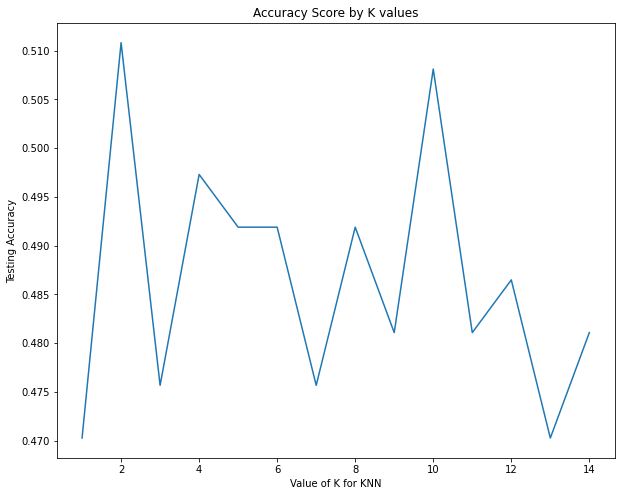

time: 662 ms


In [375]:
k = get_k_accuracy(X_train,X_test, y_train[:,0], y_test[:,0])
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train,y_train[:,0])
y_pred = knn.predict(X_test)

In [376]:
from collections import Counter

time: 1.15 ms


In [377]:
np.unique(y_test, axis=0).shape, np.unique(y_test[:,1])

((37, 2),
 array([ 10.,  16.,  17.,  19.,  20.,  25.,  30.,  31.,  43.,  46.,  52.,
         56.,  57.,  61.,  67.,  69.,  70.,  79.,  94.,  97.,  98., 110.,
        114., 118., 119., 121., 126., 127., 141., 143., 144., 146., 149.,
        154., 160., 173., 174.]))

time: 5.13 ms


Contagem das predições para cada música

In [378]:
(y_test, y_pred)

(array([[  0.,  56.],
        [  0.,  43.],
        [  1., 118.],
        [  1., 144.],
        [  1., 121.],
        [  1., 121.],
        [  0.,  25.],
        [  0.,  57.],
        [  1., 154.],
        [  0.,  19.],
        [  0.,  79.],
        [  0.,  30.],
        [  0.,  46.],
        [  1., 126.],
        [  1.,  98.],
        [  1., 119.],
        [  1., 173.],
        [  0.,  31.],
        [  1., 154.],
        [  1., 174.],
        [  0.,  67.],
        [  0.,  17.],
        [  1., 127.],
        [  0.,  16.],
        [  1., 154.],
        [  0.,  52.],
        [  0.,  79.],
        [  0.,  56.],
        [  0.,  56.],
        [  0.,  61.],
        [  0.,  16.],
        [  1., 127.],
        [  1., 154.],
        [  1., 173.],
        [  0.,  25.],
        [  1., 114.],
        [  1., 146.],
        [  1., 160.],
        [  0.,  43.],
        [  0.,  10.],
        [  1., 144.],
        [  1., 118.],
        [  1.,  97.],
        [  0.,  17.],
        [  1., 121.],
        [ 

time: 21.5 ms


In [379]:
counts = dict()
for id in np.unique(y_test[:,1]):
    counts[id] = []
print(counts)
for t, p in zip(y_test, y_pred):
    counts[t[1]].append(p)

counter = [Counter(y) for x,y in counts.items()]
counter

{10.0: [], 16.0: [], 17.0: [], 19.0: [], 20.0: [], 25.0: [], 30.0: [], 31.0: [], 43.0: [], 46.0: [], 52.0: [], 56.0: [], 57.0: [], 61.0: [], 67.0: [], 69.0: [], 70.0: [], 79.0: [], 94.0: [], 97.0: [], 98.0: [], 110.0: [], 114.0: [], 118.0: [], 119.0: [], 121.0: [], 126.0: [], 127.0: [], 141.0: [], 143.0: [], 144.0: [], 146.0: [], 149.0: [], 154.0: [], 160.0: [], 173.0: [], 174.0: []}


[Counter({0.0: 8, 1.0: 2}),
 Counter({0.0: 9, 1.0: 1}),
 Counter({0.0: 9, 1.0: 1}),
 Counter({0.0: 10}),
 Counter({0.0: 9, 1.0: 1}),
 Counter({0.0: 8, 1.0: 2}),
 Counter({0.0: 7, 1.0: 3}),
 Counter({0.0: 5, 1.0: 5}),
 Counter({0.0: 7, 1.0: 3}),
 Counter({0.0: 7, 1.0: 3}),
 Counter({0.0: 6, 1.0: 4}),
 Counter({0.0: 7, 1.0: 3}),
 Counter({0.0: 9, 1.0: 1}),
 Counter({0.0: 6, 1.0: 4}),
 Counter({0.0: 5, 1.0: 5}),
 Counter({0.0: 9, 1.0: 1}),
 Counter({0.0: 6, 1.0: 4}),
 Counter({0.0: 6, 1.0: 4}),
 Counter({0.0: 6, 1.0: 4}),
 Counter({0.0: 6, 1.0: 4}),
 Counter({0.0: 7, 1.0: 3}),
 Counter({0.0: 7, 1.0: 3}),
 Counter({0.0: 10}),
 Counter({0.0: 6, 1.0: 4}),
 Counter({0.0: 7, 1.0: 3}),
 Counter({0.0: 8, 1.0: 2}),
 Counter({0.0: 5, 1.0: 5}),
 Counter({0.0: 9, 1.0: 1}),
 Counter({0.0: 7, 1.0: 3}),
 Counter({0.0: 8, 1.0: 2}),
 Counter({0.0: 8, 1.0: 2}),
 Counter({0.0: 8, 1.0: 2}),
 Counter({0.0: 8, 1.0: 2}),
 Counter({0.0: 3, 1.0: 7}),
 Counter({0.0: 6, 1.0: 4}),
 Counter({0.0: 9, 1.0: 1}),
 Count

time: 12.3 ms


Votação das predições

In [380]:
music_y_pred = [max(x, key=x.get) for x in counter]
len(music_y_pred)
music_y_pred

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0]

time: 4.47 ms


In [381]:
music_y_test = np.unique(y_test, axis=0)[:,0]
len(music_y_test)
music_y_test

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

time: 5.96 ms


In [382]:
metrics.accuracy_score(music_y_test,music_y_pred)

0.5135135135135135

time: 5.16 ms


In [383]:
from sklearn.decomposition import PCA
import seaborn as sns

pca1 = PCA(2)
trans_pca1 = pca1.fit_transform(X_test)
trans_pca1 = pd.DataFrame(trans_pca1)
trans_pca1['Labels'] = y_test[:,0]
trans_pca1.columns = ['PC1', 'PC2','Labels']
trans_pca1.head()

,PC1,PC2,Labels
0,-2.273719,-0.240236,0.0
1,-2.421629,-0.522878,0.0
2,1.613404,1.730046,1.0
3,-2.699898,2.390708,1.0
4,6.784968,0.883557,1.0


time: 58 ms


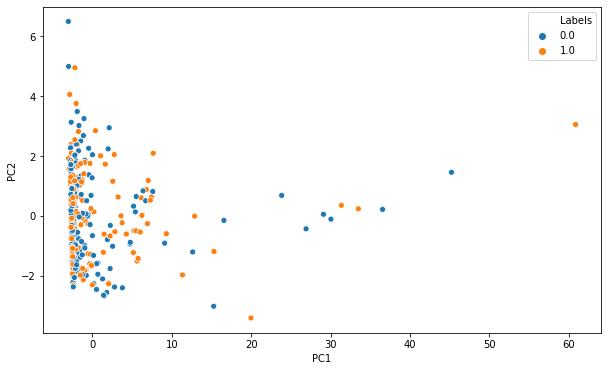

time: 277 ms


In [384]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=trans_pca1['PC1'], y=trans_pca1['PC2'], hue=trans_pca1['Labels'])